<a href="https://colab.research.google.com/github/Dhanushkumar0406/-thentamil-novels-frontend/blob/main/Video_Action_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Required Libraries

In [1]:
!pip install tensorflow opencv-python matplotlib scikit-learn tqdm kagglehub


In [4]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    BatchNormalization, TimeDistributed, LSTM, GRU, SimpleRNN, Input
)
from tensorflow.keras.utils import to_categorical


uploading the files

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pevogam/ucf101-frames")

print("Path to dataset files:", path)

Download already complete (9503357096 bytes).
Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/pevogam/ucf101-frames/versions/2


DATASET EXTRACTS AS :

ucf101_frames/

 ├── ApplyEyeMakeup/

 │    ├── v_ApplyEyeMakeup_g01_c01/
 │    │    ├── frame_0001.jpg
 │    │    ├── frame_0002.jpg


 │    │    └── ...
 ├── Archery/

 ├── BabyCrawling/
 └── ...


In [21]:
IMG_SIZE = 96              # reduced for memory
SEQUENCE_LENGTH = 8        # reduced frames
NUM_CLASSES = 4            # as requested
VIDEOS_PER_CLASS = 30      # Colab-safe
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [22]:
DATASET_PATH_TRAIN = os.path.join(path, 'train')
all_classes = sorted(os.listdir(DATASET_PATH_TRAIN))
selected_classes = all_classes[:NUM_CLASSES]

print("Selected Classes:")
for c in selected_classes:
    print("- ", c)

Selected Classes:
-  ApplyEyeMakeup
-  ApplyLipstick
-  Archery
-  BabyCrawling


In [19]:
def sample_videos(dataset_path, classes, max_videos):
    video_identifiers = []
    labels = []

    for label in classes:
        class_path = os.path.join(dataset_path, label)
        all_frames = os.listdir(class_path)

        # Extract unique video IDs from filenames (e.g., 'v_ApplyEyeMakeup_g01_c01' from 'v_ApplyEyeMakeup_g01_c01-0001.jpg')
        unique_video_ids = set()
        for frame_filename in all_frames:
            if '-' in frame_filename and frame_filename.endswith('.jpg'):
                video_id = frame_filename.split('-')[0]
                unique_video_ids.add(video_id)

        unique_video_ids = list(unique_video_ids)
        random.shuffle(unique_video_ids)

        selected_video_ids = unique_video_ids[:max_videos]

        for vid_id in selected_video_ids:
            # Store video_id and its class_path so load_video can find frames
            video_identifiers.append((vid_id, class_path))
            labels.append(label)

    return video_identifiers, labels

# video_data will now be a list of (video_id_string, class_path) tuples
video_data, video_labels = sample_videos(
    DATASET_PATH_TRAIN, selected_classes, VIDEOS_PER_CLASS
)

print("Total videos (unique identifiers):", len(video_data))

Total videos (unique identifiers): 120


In [24]:
def load_video(video_id, class_path): # Changed signature
    all_frames_in_class = sorted(os.listdir(class_path))

    # Filter frames belonging to this specific video_id
    video_frames_filenames = [
        f for f in all_frames_in_class if f.startswith(video_id) and f.endswith('.jpg')
    ]

    # Take only SEQUENCE_LENGTH frames
    selected_frames = video_frames_filenames[:SEQUENCE_LENGTH]

    sequence = []
    for f_name in selected_frames:
        img_path = os.path.join(class_path, f_name)
        img = cv2.imread(img_path)
        # Handle potential None from imread (e.g., corrupted file)
        if img is None:
            print(f"Warning: Could not read image {img_path}. Skipping.")
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0
        sequence.append(img)

    # Pad with zeros if fewer than SEQUENCE_LENGTH frames
    while len(sequence) < SEQUENCE_LENGTH:
        sequence.append(np.zeros((IMG_SIZE, IMG_SIZE, 3)))

    return np.array(sequence)

In [26]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_cat = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.25, random_state=RANDOM_SEED
)

===============================
🔶 MODEL 1 — CNN ONLY (Baseline)
===============================

In [27]:
cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,964 (15.20 MB)

 Trainable params: 3,984,964 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
cnn.fit(
    X_train[:,0],
    y_train,
    validation_split=0.2,
    epochs=8,
    batch_size=32
)

Epoch 1/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 697ms/step - accuracy: 0.3316 - loss: 1.5393 - val_accuracy: 0.3889 - val_loss: 1.2365
Epoch 2/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 530ms/step - accuracy: 0.3611 - loss: 1.3828 - val_accuracy: 0.4444 - val_loss: 1.2557
Epoch 3/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step - accuracy: 0.5187 - loss: 1.1908 - val_accuracy: 0.3333 - val_loss: 1.2995
Epoch 4/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step - accuracy: 0.5308 - loss: 1.0542 - val_accuracy: 0.5556 - val_loss: 1.1503
Epoch 5/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - accuracy: 0.6701 - loss: 0.8804 - val_accuracy: 0.6667 - val_loss: 0.9211
Epoch 6/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step - accuracy: 0.7687 - loss: 0.7741 - val_accuracy: 0.5556 - val_loss: 0.9801
Epoch 7/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step - accuracy: 0.7726 - loss: 0.6847 - val_accuracy: 0.6667 - val_loss: 0.9581
Epoch 8/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step - accuracy: 0.7491 - loss: 0.6449 - val_accuracy: 0.7222 - val_loss: 0.8378


In [25]:
X = []
y = []

# video_data is now a list of (video_id_string, class_path) tuples
for (video_id, class_path), label in tqdm(zip(video_data, video_labels), total=len(video_data)):
    X.append(load_video(video_id, class_path)) # Call with new signature
    y.append(label)

X = np.array(X)
y = np.array(y)

print("X shape: ", X.shape)
print("y shape: ", y.shape)

100%|██████████| 120/120 [00:05<00:00, 21.20it/s]


X shape:  (120, 8, 96, 96, 3)
y shape:  (120,)


In [29]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Split into training and temporary test set first
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_cat, test_size=0.25, random_state=RANDOM_SEED
)

# Split temporary training set into actual training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=RANDOM_SEED # 20% of the 75% for validation
)

===============================
🔶 MODEL 1 — CNN ONLY (Baseline)
===============================

In [33]:
cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,964 (15.20 MB)

 Trainable params: 3,984,964 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
cnn.fit(
    X_train[:,0],
    y_train,
    validation_split=0.2,
    epochs=8,
    batch_size=32
)

Epoch 1/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 664ms/step - accuracy: 0.2458 - loss: 1.7621 - val_accuracy: 0.4000 - val_loss: 1.3808
Epoch 2/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 447ms/step - accuracy: 0.3043 - loss: 2.4349 - val_accuracy: 0.3333 - val_loss: 1.4219
Epoch 3/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step - accuracy: 0.4070 - loss: 1.4556 - val_accuracy: 0.5333 - val_loss: 1.1747
Epoch 4/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step - accuracy: 0.5747 - loss: 1.0441 - val_accuracy: 0.5333 - val_loss: 1.1054
Epoch 5/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step - accuracy: 0.5422 - loss: 1.0061 - val_accuracy: 0.5333 - val_loss: 1.0261
Epoch 6/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 436ms/step - accuracy: 0.6424 - loss: 0.8544 - val_accuracy: 0.4667 - val_loss: 1.0596
Epoch 7/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step - accuracy: 0.8180 - loss: 0.6809 - val_accuracy: 0.6667 - val_loss: 0.9485
Epoch 8/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 430ms/step - accuracy: 0.9220 - loss: 0.5302 - val_accuracy: 0.6667 - val_loss: 0.7891


=====================================
🔶 MODEL 2 — RNN / LSTM / GRU
=====================================

In [38]:
feature_extractor_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = feature_extractor_input

# Iterate through the CNN layers, excluding the Dropout and final Dense layer
# This extracts features up to the Dense(128) layer
for layer in cnn.layers[:-2]: # cnn.layers[-2] is Dropout, cnn.layers[-1] is final Dense
    x = layer(x)

feature_extractor = Model(inputs=feature_extractor_input, outputs=x)

In [39]:
def extract_features(X):
    features = []
    for video in tqdm(X):
        video_features = []
        for frame in video:
            frame = np.expand_dims(frame, axis=0)
            video_features.append(feature_extractor.predict(frame, verbose=0)[0])
        features.append(video_features)
    return np.array(features)

X_train_feat = extract_features(X_train)
X_val_feat   = extract_features(X_val)
X_test_feat  = extract_features(X_test)

100%|██████████| 30/30 [00:23<00:00,  1.28it/s]


In [40]:
lstm_model = Sequential([
    LSTM(128, input_shape=(SEQUENCE_LENGTH, X_train_feat.shape[2])),
    Dense(NUM_CLASSES, activation='softmax')
])

lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

lstm_model.fit(
    X_train_feat, y_train,
    validation_data=(X_val_feat, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.1706 - loss: 1.4591 - val_accuracy: 0.6667 - val_loss: 1.1707
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8090 - loss: 0.9822 - val_accuracy: 0.6667 - val_loss: 1.0172
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8455 - loss: 0.7168 - val_accuracy: 0.7222 - val_loss: 0.8801
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8555 - loss: 0.5681 - val_accuracy: 0.7778 - val_loss: 0.7937
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8898 - loss: 0.4461 - val_accuracy: 0.6667 - val_loss: 0.7970
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8945 - loss: 0.3368 - val_accuracy: 0.6667 - val_loss: 0.8553
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8859 - loss: 0.3054 - val_accuracy: 0.7778 - val_loss: 0.8850
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8819 - loss: 0.2712 - val_accuracy: 0.7778 - val_loss: 0.9495
Epoch 9/10

=====================================
🔶 MODEL 3 — CNN + LSTM HYBRID
=====================================

In [41]:
input_layer = Input(shape=(SEQUENCE_LENGTH, IMG_SIZE, IMG_SIZE, 3))

x = TimeDistributed(Conv2D(32, (3,3), activation='relu'))(input_layer)
x = TimeDistributed(MaxPooling2D())(x)
x = TimeDistributed(Conv2D(64, (3,3), activation='relu'))(x)
x = TimeDistributed(MaxPooling2D())(x)
x = TimeDistributed(Flatten())(x)

x = LSTM(128)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

hybrid_model = Model(input_layer, output)

hybrid_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

hybrid_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 8, 96, 96, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 8, 94, 94, 32)  │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 8, 47, 47, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 8, 45, 45, 64)  │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 8, 22, 22, 64)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 8, 30976)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │    15,925,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,945,668 (60.83 MB)

 Trainable params: 15,945,668 (60.83 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
hybrid_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=8
)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.3346 - loss: 2.5192 - val_accuracy: 0.1667 - val_loss: 1.5045
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.4456 - loss: 1.2751 - val_accuracy: 0.4444 - val_loss: 1.1817
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.6077 - loss: 1.0574 - val_accuracy: 0.5000 - val_loss: 1.1678
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.7407 - loss: 0.9188 - val_accuracy: 0.6111 - val_loss: 1.0013
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.6987 - loss: 0.7691 - val_accuracy: 0.7222 - val_loss: 0.7562
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9619 - loss: 0.5069 - val_accuracy: 0.6667 - val_loss: 0.8884
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9166 - loss: 0.4837 - val_accuracy: 0.7778 - val_loss: 0.7643
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9506 - loss: 0.4540 - val_accuracy: 0.7778 - val_loss: 0.7852
Epoch 9/

=====================================
🔶 EVALUATION & COMPARISON
=====================================

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
                precision    recall  f1-score   support

ApplyEyeMakeup       0.73      1.00      0.84         8
 ApplyLipstick       1.00      0.88      0.93         8
       Archery       0.86      0.75      0.80         8
  BabyCrawling       0.80      0.67      0.73         6

      accuracy                           0.83        30
     macro avg       0.85      0.82      0.83        30
  weighted avg       0.85      0.83      0.83        30



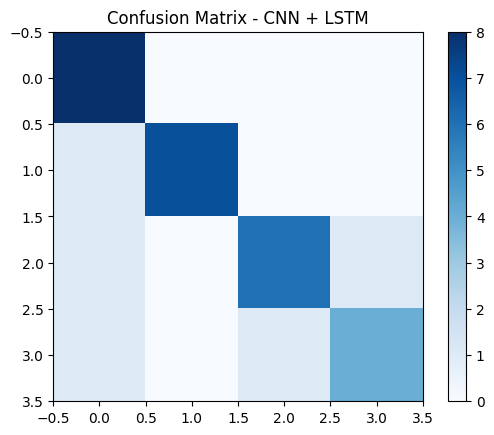

In [43]:
y_pred = np.argmax(hybrid_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred, target_names=encoder.classes_))

cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix - CNN + LSTM")
plt.colorbar()
plt.show()


In [45]:
cnn.save("cnn_baseline.h5")
lstm_model.save("lstm_model.h5")
hybrid_model.save("cnn_lstm_hybrid.h5")